In [1]:
from scipy.linalg import solve
from scipy.special import erf
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import multiprocessing as mp
import sklearn
from sklearn.metrics import auc
%matplotlib inline

In [2]:
with open('combined_data.pkl', 'rb') as f:
    data = pkl.load(f)
x = data['EYZ']
y = x[0,:]

In [3]:
def test(j):
    x = data['EYZ']
    for i in range (x.shape[0]):
        x[i][x[i] < 0] = 0
        x[i] = x[i]*10**5
        x[i][x[i] > 1] = 1
    return x

In [4]:
# j = 3
# new_data = test(j)
# while (np.count_nonzero(new_data) == 0):
#     j += 1
#     new_data = test(j)
#     print(j)
# x = test(7)

In [5]:
train_frac = 0.8
n_seconds = x.shape[1] #-1 to account for when t=n
t = np.arange(n_seconds)
split = int(n_seconds * train_frac)
t_train, t_test = t[:split], t[split:]
l = float(len(t_train)-1)
t_train1, t_train2 = t_train[:-1], t_train[1:]
t_test1, t_test2 = t_test[:-1], t_test[1:]

In [6]:
def fit(i, iters=500, atol=1e-8):
    x = data['EYZ']
    y = x[i,1:]-x[i,:-1]

    x_train = x[:, t_train]
    x_train1, x_test1 = x[:,t_train1], x[:,t_test1]

    s = np.sign((y[t_train1]))
    c = np.cov(x_train)
#     c = np.cov(x_train1)

    x0 = (x_train1 - x_train.mean(1)[:, np.newaxis]) / l

    w = np.zeros(x.shape[0]) #272 channels
    w[0] = 1

    erf_last = np.inf
    e = []
#     d = []

    for it in range(iters):
        h = w.dot(x_train1)
        
        sig = np.std(y[t_train1] - w.dot(x[:, t_train1]))
        
        erf_next = erf(h/(np.sqrt(2)*sig))
#         d.append(np.linalg.norm(y[t_train2]-h/np.sqrt(2))**2)
        ei = np.linalg.norm(erf_next - erf_last) 
        e.append(ei)
        if ei * ei < atol:
            break
        erf_last = erf_next.copy()

        h *= s / erf_next
        
        w = solve(c, x0.dot(h))
    return w, e

In [7]:
res = [fit(i) for i in range(data['EYZ'].shape[0])]
w = np.vstack([r[0] for r in res])
e = [r[1] for r in res]

# import pickle
# with open('e.pkl', 'wb') as f:
#      pickle.dump(e, f)
# f.close()

# fileObject = open('w.pkl','rb')  
# w = pickle.load(fileObject) 
# fileObject = open('e.pkl','rb')  
# e = pickle.load(fileObject) 

# fig, ax = plt.subplots(1, 1, figsize=(4,4))
# for ei in d[:5]:
#     ei = ei[1:]
#     ax.plot(ei, 'k-', lw=0.1)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('iteration')
# ax.set_ylabel('discrepancy')
# plt.tight_layout()
# plt.show()

In [10]:
temp = x.shape[0]
train_prediction = np.empty((temp, len(t_train2)))
test_prediction = np.empty((temp, len(t_test2)))

for i in range(temp-1): #num of channels
    y = x[i,1:]-x[i,:-1]
    train_prediction[i] = w[i].dot(x[:,t_train1]) + np.mean(y[t_train1] - w[i].dot(x[:,t_train1]))
    test_prediction[i] = w[i].dot(x[:,t_test1]) + np.mean(y[t_train1] - w[i].dot(x[:,t_train1]))

#     train_prediction[i] = x[i, t_train1] + w[i].dot(x[:,t_train1])
#     test_prediction[i] = x[i, t_test1] + w[i].dot(x[:,t_test1])

#     train_prediction[i][train_prediction[i] < 0] = 0
#     test_prediction[i][test_prediction[i] < 0] = 0
#     train_prediction[i][train_prediction[i] > 1] = 1
#     test_prediction[i][test_prediction[i] > 1] = 1

In [11]:
import pickle
with open ('train_prediction_xtrain.pkl', 'wb') as f:
    pkl.dump(train_prediction, f)
f.close()
with open ('test_prediction_xtrain.pkl', 'wb') as f:
    pkl.dump(test_prediction, f)
f.close()
# with open ('w_xtrain.pkl', 'wb') as f:
#     pkl.dump(w, f)
# f.close()
# with open ('e_xtrain.pkl', 'wb') as f:
#     pkl.dump(e, f)
# f.close()


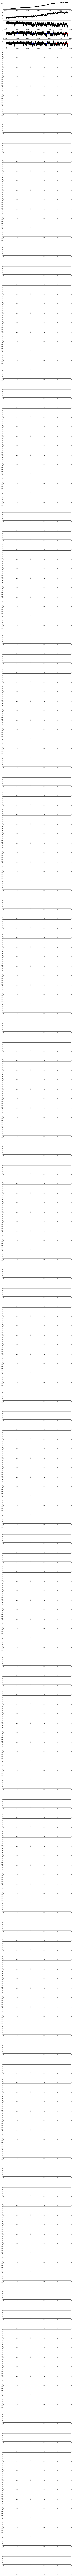

In [12]:
fig, ax = plt.subplots(x.shape[0], 1, figsize=(14, 2*x.shape[0]))
for i in range (5):# (x.shape[0]):
    ax[i].plot(t_train2, train_prediction[i], 'b-',
               t_test2, test_prediction[i], 'r-',
               t, x[i], 'k-', clip_on=False)
plt.show()